In [1]:
!pip install -qq transformers diffusers pytorch_lightning accelerate

# Text2Image

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-2-c2625f7333d6>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_preds = unet.forward(latents_inputs, torch.tensor(t).to(torch_device), encoder_hidden_states=embeddings)


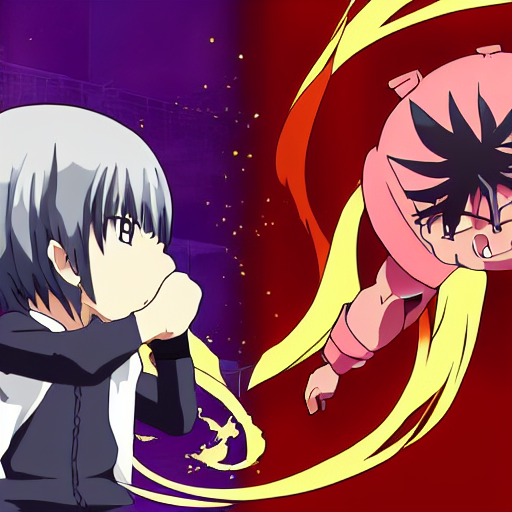

In [2]:
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel

from PIL import Image
from torch import autocast
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

# ---------------------------------------------------------------------------- #
#                              Inference Pipeline                              #
# ---------------------------------------------------------------------------- #
prompt = ["A picture of 2 anime characters fighting"]
generator = torch.manual_seed(32)
num_inference_timesteps = 50
height = 512
width  = 512
batch_size = 1
guidance_scale = 8

# -------------------------- Set Inference Timesteps ------------------------- #
scheduler.set_timesteps(num_inference_steps=num_inference_timesteps)

latents = torch.randn((batch_size, unet.config.in_channels, height//8, width//8), generator=generator)
latents = latents * scheduler.init_noise_sigma

prompt_embeds = tokenizer(prompt, return_tensors="pt", max_length=tokenizer.model_max_length, truncation=True, padding="max_length")
uncond_embeds = tokenizer([""], return_tensors="pt", max_length=prompt_embeds.input_ids.shape[-1], truncation=True, padding="max_length")

with torch.no_grad():
    prompt_embeds = text_encoder(prompt_embeds.input_ids.to(torch_device)).last_hidden_state
    uncond_embeds = text_encoder(uncond_embeds.input_ids.to(torch_device)).last_hidden_state
    embeddings = torch.cat([uncond_embeds, prompt_embeds]).to(torch_device)

with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        latents_inputs = torch.cat([latents]*2).to(torch_device)
        latents_inputs = scheduler.scale_model_input(latents_inputs, t)

        with torch.no_grad():
            noise_preds = unet.forward(latents_inputs, torch.tensor(t).to(torch_device), encoder_hidden_states=embeddings)
        
        uncond_noise, prompt_noise = noise_preds.sample.chunk(2)
        noise = uncond_noise + guidance_scale * (prompt_noise - uncond_noise)

        latents = scheduler.step(noise, t, latents.to(torch_device)).prev_sample

latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


# Image2Image

In [4]:
! curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg' 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0  91121      0 --:--:-- --:--:-- --:--:-- 90988


  0%|          | 0/50 [00:00<?, ?it/s]

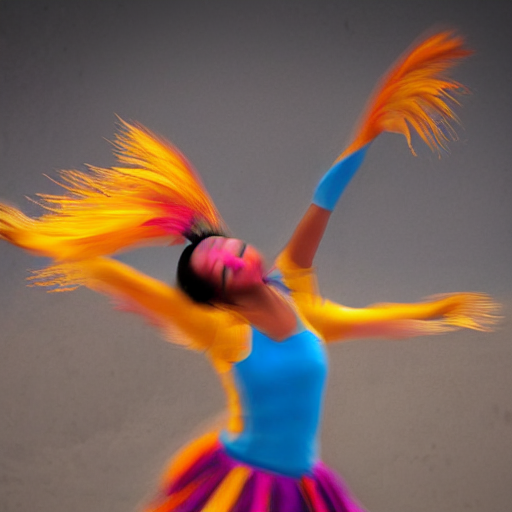

In [19]:
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel

from PIL import Image
from torch import autocast
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
from torchvision import transforms as tfms


# ---------------------------------------------------------------------------- #
#                              Inference Pipeline                              #
# ---------------------------------------------------------------------------- #
prompt = ["A colorful dancer, nat geo photo"]
# generator = torch.manual_seed(32)
num_inference_timesteps = 50
height = 512
width  = 512
batch_size = 2
guidance_scale = 5

input_image = Image.open('macaw.jpg').resize((512, 512))

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images


encoded = pil_to_latent(input_image)
'''
We want to convert one image to another. So, what we can do is, use the prompt for guidance, and we can also start from src
image itself. So, what we do to do the denoising process is use the VAE output of the source image and then add noise to the latents.
Hopefully, the final latents we land on, when upscaled can give us what we want.
'''
start_step = 0
scheduler.set_timesteps(num_inference_steps=num_inference_timesteps)
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

prompt_embeds = tokenizer(prompt, return_tensors="pt", max_length=tokenizer.model_max_length, truncation=True, padding="max_length")
uncond_embeds = tokenizer([""], return_tensors="pt", max_length=prompt_embeds.input_ids.shape[-1], truncation=True, padding="max_length")

with torch.no_grad():
    prompt_embeds = text_encoder(prompt_embeds.input_ids.to(torch_device)).last_hidden_state
    uncond_embeds = text_encoder(uncond_embeds.input_ids.to(torch_device)).last_hidden_state
    embeddings = torch.cat([uncond_embeds, prompt_embeds])

with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        if i >= start_step:
            latent_input = torch.cat([latents]*2).to(torch_device)
            latent_input = scheduler.scale_model_input(latent_input, t)

            with torch.no_grad():
                noise_preds = unet.forward(latent_input, t, encoder_hidden_states=embeddings).sample

            uncond_noise, prompt_noise = noise_preds.chunk(2)
            noise = uncond_noise + guidance_scale * (prompt_noise - uncond_noise)

            latents = scheduler.step(noise, t, latents).prev_sample

latents_to_pil(latents)[0]